# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you do not have a GPU, uncomment and run the next commands.


In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import gc

In [5]:
tf.__version__

'2.7.0'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [8]:
from efficientnet_lite import EfficientNetLiteB0

In [9]:
seed = 42

# 2. Utility Functions

You can use this function to load your training data.

In [10]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [11]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [12]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [13]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [14]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [15]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [16]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [17]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [18]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [19]:
x_train[0]

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[26., 45., 47.],
        [26., 46., 48.],
        [27., 45., 48.],
        ...,
        [26., 47., 48.],
        [27., 48., 46.],
        [28., 47., 48.]],

       [[26., 45., 48.],
        [26., 46., 49.],
        [27., 45., 50.],
        ...,
        [26., 46., 48.],
        [27., 46., 46.],
        [28., 45., 48.]],

       [[27., 46., 48.],
        [27., 45., 49.],
        [27., 46., 49.],
        ...,
        [27., 46., 49.],
        [27., 47., 48.],
        [27., 45., 49.]],

       ...,

       [[27., 47., 51.],
        [28., 47., 50.],
        [28., 47., 49.],
        ...,
        [27., 47., 49.],
        [27., 47., 47.],
        [27., 46., 49.]],

       [[27., 46., 51.],
        [27., 47., 50.],
        [28., 48., 49.],
        ...,
        [27., 46., 50.],
        [27., 48., 48.],
        [27., 47., 48.]],

       [[27., 47., 50.],
        [27., 48., 50.],
        [28., 47., 50.],
        ...,
        [27., 44., 

In [20]:
y_train.shape

TensorShape([80])

In [21]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

In [22]:
x_train = x_train.numpy().astype(np.int32)
y_train = y_train.numpy()

### Augment images

In [23]:
image_to_visualize = 24

#### Rotate images

90 degrees counterclockwise

Class: Mountain


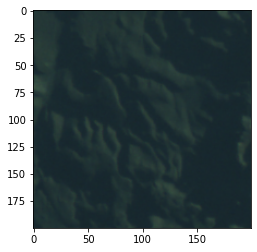

In [24]:
visualize_image(x_train, y_train, image_to_visualize)

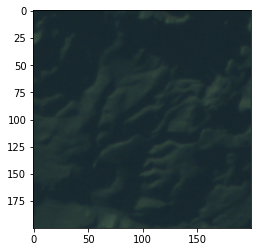

In [25]:
plt.imshow(np.rot90(x_train[image_to_visualize], k=1, axes=(0, 1)))

In [26]:
x_train_rot90_ccw = np.rot90(x_train, axes=(1,2))
x_train_rot90_ccw.shape

(80, 200, 200, 3)

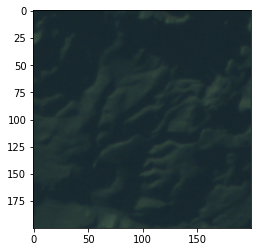

In [27]:
plt.imshow(x_train_rot90_ccw[image_to_visualize])

In [28]:
x_train_augmented = np.vstack([x_train, x_train_rot90_ccw])
x_train_augmented.shape

(160, 200, 200, 3)

In [29]:
y_train_augmented = np.concatenate([y_train, y_train])
y_train_augmented.shape

(160,)

180 degrees

Class: Mountain


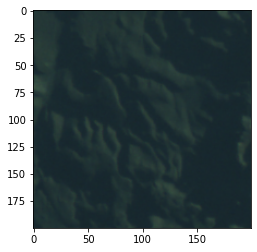

In [30]:
visualize_image(x_train, y_train, image_to_visualize)

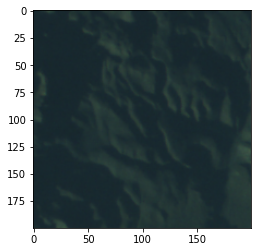

In [31]:
plt.imshow(np.rot90(np.rot90(x_train[image_to_visualize], k=1, axes=(0, 1)), k=1, axes=(0, 1)))

In [32]:
x_train_rot180 = np.rot90(np.rot90(x_train, axes=(1,2)), axes=(1,2))
x_train_rot180.shape

(80, 200, 200, 3)

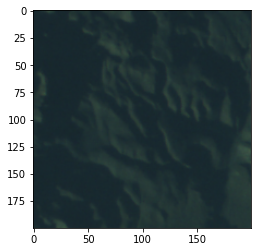

In [33]:
plt.imshow(x_train_rot180[image_to_visualize])

In [34]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot180])
x_train_augmented.shape

(240, 200, 200, 3)

In [35]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(240,)

90 degrees clockwise

Class: Mountain


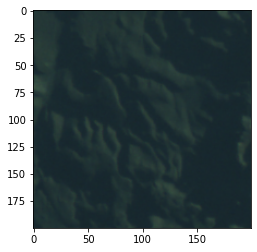

In [36]:
visualize_image(x_train, y_train, image_to_visualize)

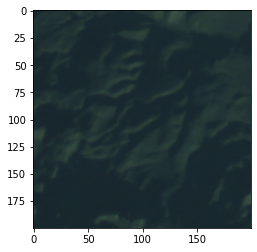

In [37]:
plt.imshow(np.rot90(x_train[image_to_visualize], k=-1, axes=(0, 1)))

In [38]:
x_train_rot90_cw = np.rot90(x_train, axes=(2,1))
x_train_rot90_cw.shape

(80, 200, 200, 3)

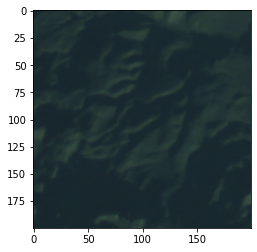

In [39]:
plt.imshow(x_train_rot90_cw[image_to_visualize])

In [40]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw])
x_train_augmented.shape

(320, 200, 200, 3)

In [41]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(320,)

#### Flip images

Up/down

Class: Mountain


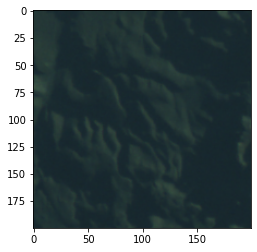

In [42]:
visualize_image(x_train, y_train, image_to_visualize)

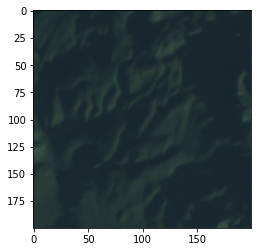

In [43]:
plt.imshow(np.flipud(x_train[image_to_visualize]))

In [44]:
x_train_flipud = np.array([np.flipud(i) for i in x_train])
x_train_flipud.shape

(80, 200, 200, 3)

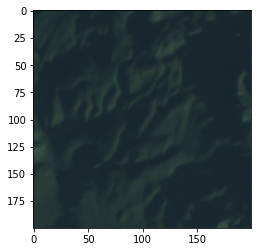

In [45]:
plt.imshow(x_train_flipud[image_to_visualize])

In [46]:
x_train_augmented = np.vstack([x_train_augmented, x_train_flipud])
x_train_augmented.shape

(400, 200, 200, 3)

In [47]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(400,)

Left/right

Class: Mountain


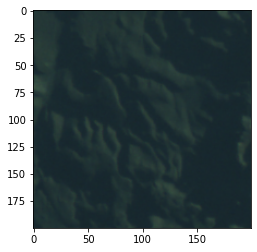

In [48]:
visualize_image(x_train, y_train, image_to_visualize)

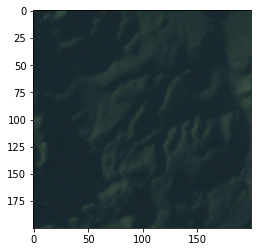

In [49]:
plt.imshow(np.fliplr(x_train[image_to_visualize]))

In [50]:
x_train_fliplr = np.array([np.fliplr(i) for i in x_train])
x_train_fliplr.shape

(80, 200, 200, 3)

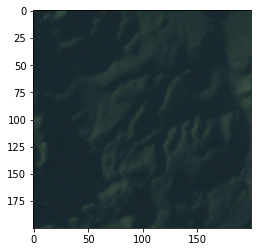

In [51]:
plt.imshow(x_train_fliplr[image_to_visualize])

In [52]:
x_train_augmented = np.vstack([x_train_augmented, x_train_fliplr])
x_train_augmented.shape

(480, 200, 200, 3)

In [53]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(480,)

#### Flip rotated images up/down

Skip the following variations since these images already exist:

- rot180 ud
- rot90 ccw lr
- rot90 cw lr

90 degrees counterclockwise up/down

Class: Mountain


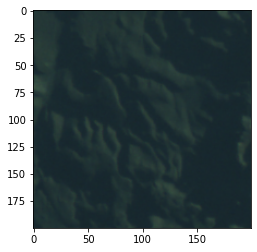

In [54]:
visualize_image(x_train, y_train, image_to_visualize)

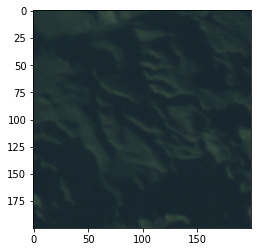

In [55]:
plt.imshow(np.flipud(x_train_rot90_ccw[image_to_visualize]))

In [56]:
x_train_rot90_ccw_flipud = np.array([np.flipud(i) for i in x_train_rot90_ccw])
x_train_rot90_ccw_flipud.shape

(80, 200, 200, 3)

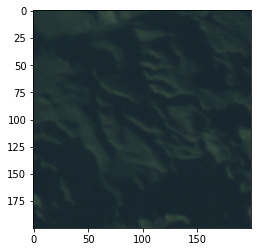

In [57]:
plt.imshow(x_train_rot90_ccw_flipud[image_to_visualize])

In [58]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_ccw_flipud])
x_train_augmented.shape

(560, 200, 200, 3)

In [59]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(560,)

90 degrees clockwise up/down

Class: Mountain


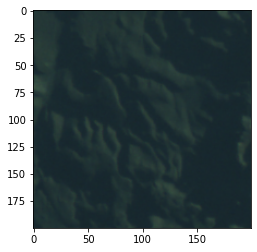

In [60]:
visualize_image(x_train, y_train, image_to_visualize)

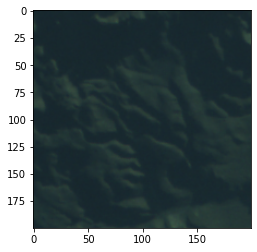

In [61]:
plt.imshow(np.flipud(x_train_rot90_cw[image_to_visualize]))

In [62]:
x_train_rot90_cw_flipud = np.array([np.flipud(i) for i in x_train_rot90_cw])
x_train_rot90_cw_flipud.shape

(80, 200, 200, 3)

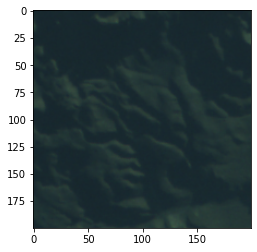

In [63]:
plt.imshow(x_train_rot90_cw_flipud[image_to_visualize])

In [64]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw_flipud])
x_train_augmented.shape

(640, 200, 200, 3)

In [65]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(640,)

### Split images in training and validation sets

In [66]:
x_train_augmented_shuffled, y_train_augmented_shuffled = shuffle(x_train_augmented, y_train_augmented, random_state=seed)

x_train, x_val, y_train, y_val = train_test_split(x_train_augmented_shuffled, y_train_augmented_shuffled, test_size=0.2, random_state=seed)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(512, 200, 200, 3) (512,) (128, 200, 200, 3) (128,)


#### Rotate images by 45, 135, 225 and 315 degrees

Class: River


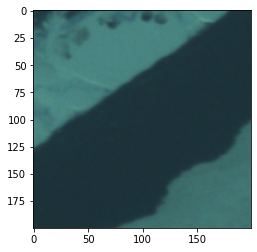

In [67]:
visualize_image(x_train, y_train, image_to_visualize)

In [68]:
from scipy import ndimage

In [69]:
max_index = int(round(len(x_train) * 0.1, 0))
max_index

51

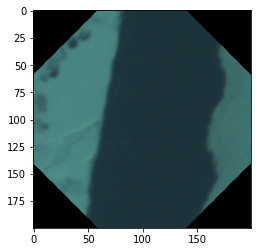

In [70]:
rotated_45 = ndimage.rotate(x_train[image_to_visualize], 45, reshape=False)
plt.imshow(rotated_45)

In [71]:
x_train_rot_45 = np.array([ndimage.rotate(i, 45, reshape=False) for i in x_train[:max_index]])
x_train_rot_45.shape

(51, 200, 200, 3)

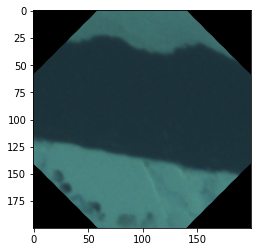

In [72]:
rotated_135 = ndimage.rotate(x_train[image_to_visualize], 135, reshape=False)
plt.imshow(rotated_135)

In [73]:
x_train_rot_135 = np.array([ndimage.rotate(i, 135, reshape=False) for i in x_train[:max_index]])
x_train_rot_135.shape

(51, 200, 200, 3)

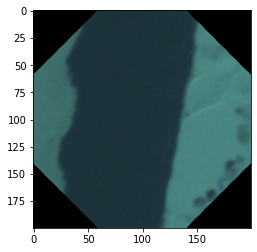

In [74]:
rotated_225 = ndimage.rotate(x_train[image_to_visualize], 225, reshape=False)
plt.imshow(rotated_225)

In [75]:
x_train_rot_225 = np.array([ndimage.rotate(i, 225, reshape=False) for i in x_train[:max_index]])
x_train_rot_225.shape

(51, 200, 200, 3)

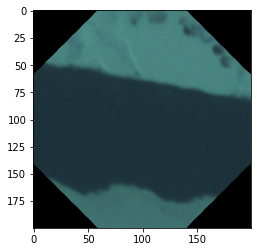

In [76]:
rotated_315 = ndimage.rotate(x_train[image_to_visualize], 315, reshape=False)
plt.imshow(rotated_315)

In [77]:
x_train_rot_315 = np.array([ndimage.rotate(i, 315, reshape=False) for i in x_train[:max_index]])
x_train_rot_315.shape

(51, 200, 200, 3)

In [78]:
x_train = np.vstack([x_train, x_train_rot_45])
x_train = np.vstack([x_train, x_train_rot_135])
x_train = np.vstack([x_train, x_train_rot_225])
x_train = np.vstack([x_train, x_train_rot_315])
x_train.shape

(716, 200, 200, 3)

In [79]:
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train.shape

(716,)

### Add Gaussian noise to images

Try out more noise? -> https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise

Class: River


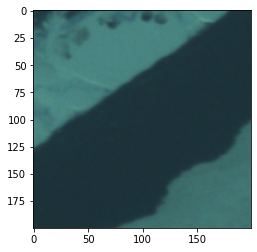

In [80]:
visualize_image(x_train, y_train, image_to_visualize)

In [81]:
np.random.seed(seed)

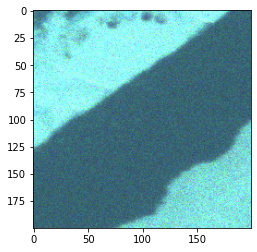

In [82]:
noise = np.random.normal(x_train[image_to_visualize], 0.2 * x_train[image_to_visualize])
noisy_image = np.round(x_train[image_to_visualize] + noise, 0).astype(np.int32)
plt.imshow(noisy_image)

In [83]:
x_train_noise = np.array([np.round(i + (np.random.normal(i, 0.2 * i)), 0) for i in x_train[:max_index]]).astype(np.int32)
x_train_noise.shape

(51, 200, 200, 3)

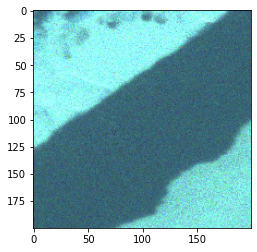

In [84]:
plt.imshow(x_train_noise[image_to_visualize])

In [85]:
x_train = np.vstack([x_train, x_train_noise])
x_train.shape

(767, 200, 200, 3)

In [86]:
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train.shape

(767,)

### Normalize images

Does this really make sense given that a) the scale of the pixel values is changed and b) the same transformation cannot be applied to the private test set.

Class: River


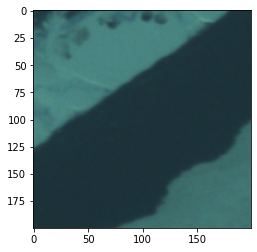

In [87]:
visualize_image(x_train, y_train, image_to_visualize)

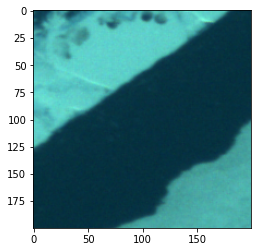

In [88]:
norm = (x_train[image_to_visualize] - np.min(x_train[image_to_visualize])) / (np.max(x_train[image_to_visualize]) - np.min(x_train[image_to_visualize]))
plt.imshow(norm)

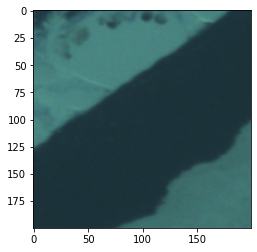

In [89]:
norm2 = (x_train[image_to_visualize]/255)
plt.imshow(norm2)

#### Histogram equalization

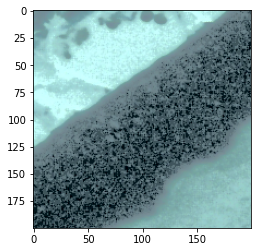

In [90]:
# https://stackoverflow.com/questions/42651595/histogram-equalization-python-for-colored-image

import cv2

img = x_train[image_to_visualize].astype(np.uint8)

img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

y_eq = cv2.equalizeHist(y)

img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)

plt.imshow(img_rgb_eq)

In [91]:
equalized_images = []

for i in x_train[:max_index]:

  img = i.astype(np.uint8)

  img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  y, cr, cb = cv2.split(img_y_cr_cb)

  y_eq = cv2.equalizeHist(y)

  img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
  img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)

  equalized_images.append(img_rgb_eq)

equalized_images = np.array(equalized_images)
equalized_images.shape

(51, 200, 200, 3)

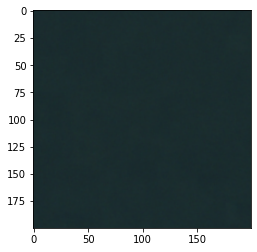

In [92]:
plt.imshow(i)

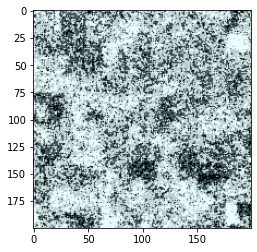

In [93]:
plt.imshow(img_rgb_eq)

In [94]:
x_train = np.vstack([x_train, equalized_images])
x_train.shape

(818, 200, 200, 3)

In [95]:
y_train = np.concatenate([y_train, y_train[:max_index]])
y_train.shape

(818,)

In [96]:
del x_train_augmented, y_train_augmented, x_train_augmented_shuffled, y_train_augmented_shuffled
gc.collect()

20425

# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [97]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [98]:
tf.random.set_seed(seed)

In [99]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [100]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train, dtype=np.int32)

x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val, dtype=np.int32)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(818, 200, 200, 3) (818,) (128, 200, 200, 3) (128,)


In [101]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val, y_val))

Epoch 1/100
103/103 [==============================] - 22s 72ms/step - loss: 4.6023 - sparse_categorical_accuracy: 0.1699 - val_loss: 2.8267 - val_sparse_categorical_accuracy: 0.1953
Epoch 2/100
103/103 [==============================] - 6s 57ms/step - loss: 3.2929 - sparse_categorical_accuracy: 0.1773 - val_loss: 7.9809 - val_sparse_categorical_accuracy: 0.1094
Epoch 3/100
103/103 [==============================] - 6s 57ms/step - loss: 2.8601 - sparse_categorical_accuracy: 0.1870 - val_loss: 3.6704 - val_sparse_categorical_accuracy: 0.1562
Epoch 4/100
103/103 [==============================] - 6s 57ms/step - loss: 2.5970 - sparse_categorical_accuracy: 0.1858 - val_loss: 3.7596 - val_sparse_categorical_accuracy: 0.2734
Epoch 5/100
103/103 [==============================] - 7s 64ms/step - loss: 2.3703 - sparse_categorical_accuracy: 0.2237 - val_loss: 2.1472 - val_sparse_categorical_accuracy: 0.2734
Epoch 6/100
103/103 [==============================] - 6s 62ms/step - loss: 2.2148 - spar

In [102]:
gc.collect()

1673

### Plot loss and accuracy

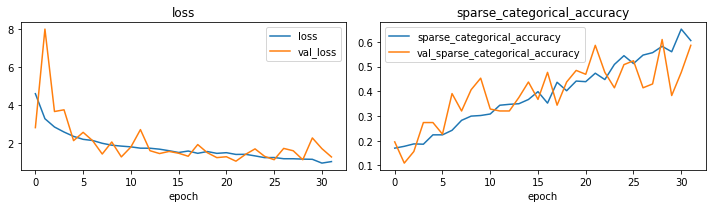

In [103]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [104]:
predictions = evaluate_model(x_train, y_train)

Score: 0.4830171240789709


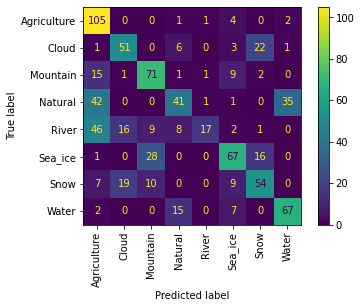

In [105]:
get_confusion_matrix(y_train, predictions)

Class: River
Predicted: Agriculture


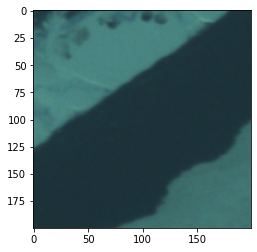

In [106]:
visualize_image(x_train.numpy().astype(int), y_train.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [107]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

Accuracy: 0.578
Precision: 0.578
Recall: 0.578
F1-Score: 0.578
              precision    recall  f1-score   support

           0       0.48      0.93      0.63       113
           1       0.59      0.61      0.60        84
           2       0.60      0.71      0.65       100
           3       0.57      0.34      0.43       120
           4       0.85      0.17      0.29        99
           5       0.66      0.60      0.63       112
           6       0.57      0.55      0.56        99
           7       0.64      0.74      0.68        91

    accuracy                           0.58       818
   macro avg       0.62      0.58      0.56       818
weighted avg       0.62      0.58      0.55       818



### Evaluation on val set

In [108]:
predictions = evaluate_model(x_val, y_val)

Score: 0.47690685413005274


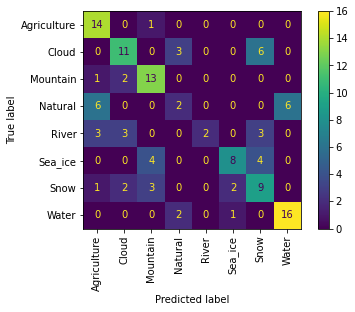

In [109]:
get_confusion_matrix(y_val, predictions)

Class: Mountain
Predicted: Mountain


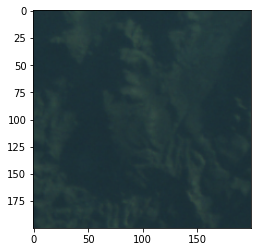

In [110]:
visualize_image(x_val.numpy().astype(int), y_val.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [111]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

Accuracy: 0.586
Precision: 0.586
Recall: 0.586
F1-Score: 0.586
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        15
           1       0.61      0.55      0.58        20
           2       0.62      0.81      0.70        16
           3       0.29      0.14      0.19        14
           4       1.00      0.18      0.31        11
           5       0.73      0.50      0.59        16
           6       0.41      0.53      0.46        17
           7       0.73      0.84      0.78        19

    accuracy                           0.59       128
   macro avg       0.62      0.56      0.54       128
weighted avg       0.61      0.59      0.56       128



# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [112]:
#Saving model
model.save_weights('v20.h5')

The trained model can be also loaded for further testing. 

In [113]:
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v20.h5')

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same


The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [114]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train, y_train)

Score: 0.4830171240789709
